In [1]:
from __future__ import division, print_function, absolute_import
import logging

import os
import numpy as np
from config import pathDict
from conv_net.train import Train
from conv_net.test import Test
from data_transformation.data_prep import get_valid_land_house_ids, dumpStratifiedBatches_balanced_class
from plot import Plot
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


images_per_label = None # normally 5000 each label is good
assessor_img_type = 'assessor'
aerial_img_type = 'google_aerial' # 'bing_aerial'
overlayed_img_type = 'google_overlayed'
streetside_img_type = None


image_type = overlayed_img_type#assessor_img_type#aerial_img_type###

if image_type == 'assessor':
    inp_image_shape = [260, 260, 3]
elif image_type == 'google_aerial':
    inp_image_shape = [400, 400, 3]
elif image_type == 'google_overlayed':
    inp_image_shape = [400, 400, 3]
elif image_type == 'google_streetside':
    inp_image_shape = [260, 260, 3]
else:
    raise ValueError('Not a valid image type provided')
    
which_net = 'resnet'
max_batches = 75
tr_batch_size = 128

batch_prepare = False
train = False
test = True

## PREPARE/DUMP BATCHES:

In [2]:
if batch_prepare:
    cmn_land_pins, cmn_house_pins = get_valid_land_house_ids(
            aerial_img_type=aerial_img_type,
            streetside_img_type=streetside_img_type,
            overlayed_img_type=overlayed_img_type,
            images_per_label=images_per_label)
    print (len(cmn_land_pins), len(cmn_house_pins))

    tr_batch_size = 128
    cv_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    
    dumpStratifiedBatches_balanced_class(cmn_land_pins, cmn_house_pins, img_resize_shape=inp_image_shape,
                                         image_type=image_type, cv_batch_size=cv_batch_size, tr_batch_size=tr_batch_size,
                                         shuffle_seed=873, get_stats=True, max_batches=max_batches)


## Overlayed Images [central crop : 96x96x3]

#### TRAIN MODEL :

In [2]:
if train:
    tr_obj = Train(dict(inp_img_shape=[400,400,3],
                   crop_shape=[96,96,3],
                   out_img_shape=[224, 224, 3],
                   use_checkpoint=True,
                   save_checkpoint=True,
                   write_tensorboard_summary=False
                   ),
              which_net=which_net,  # vgg
              image_type=image_type)
    tr_acc_arr, tr_loss_arr, cv_acc_arr, cv_loss_arr = tr_obj.run(num_epochs=3, num_batches=max_batches)# + 1)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
[]
Checkpoints not found, Hence starting at batch 0 and epoch 0........


In [6]:
print ('Mean Values: train_loss = %s, train_acc = %s, cv_loss = %s, cv_acc = %s' %(str(np.mean(tr_loss_arr)), str(np.mean(tr_acc_arr)), str(np.mean(cv_loss_arr)), str(np.mean(cv_acc_arr))))

Mean Values: train_loss = 5.31856, train_acc = 0.855764, cv_loss = 3.2502, cv_acc = 0.841736


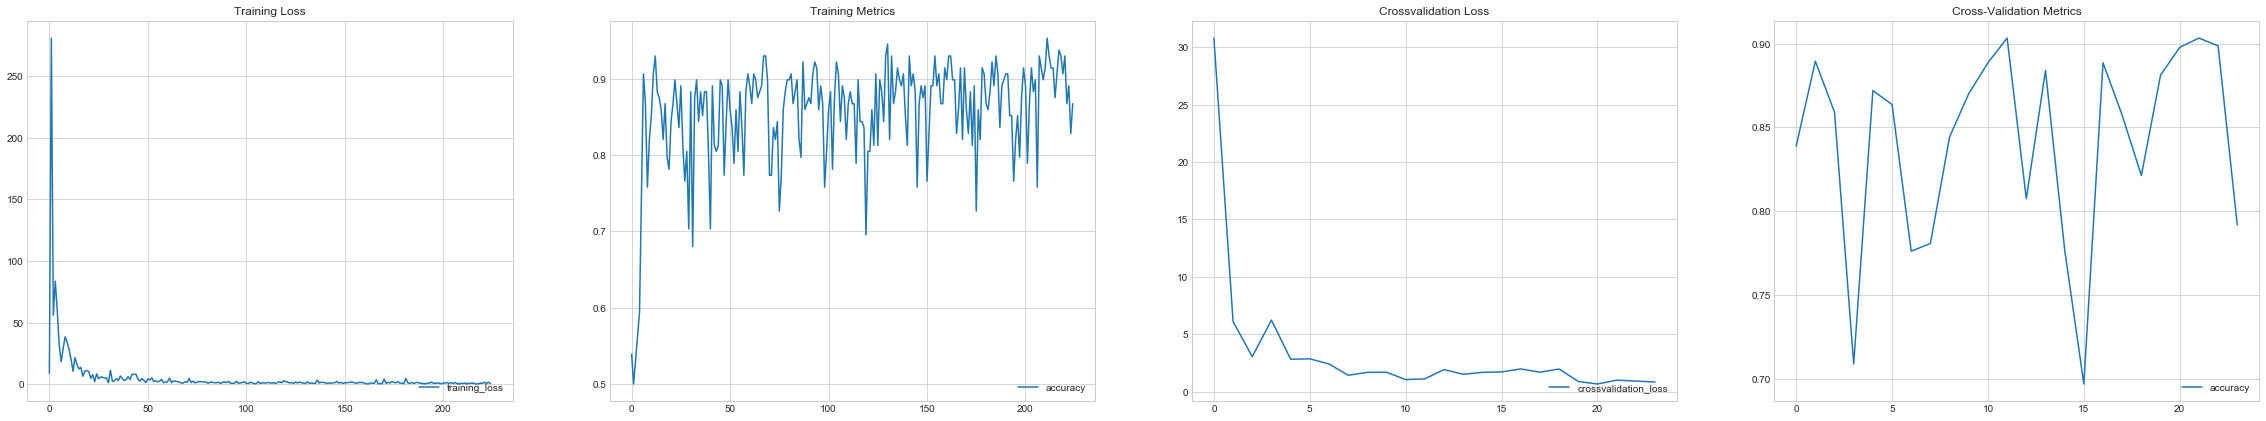

In [17]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(tr_acc_arr, columns=['accuracy'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(cv_acc_arr, columns=['accuracy'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

#### TEST MODEL: (Use the same Cross Validation set)

In [2]:
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    ts_loss_arr, ts_acc_arr, ts_precision_arr, ts_recall_arr = tsoj.run(dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Test Graphs: RESNET
INFO:tensorflow:Restoring parameters from /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet/resnet_epoch_0_batch_49
Test Graphs: RESNET
INFO:tensorflow:Restoring parameters from /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet/resnet_epoch_0_batch_59
Test Graphs: RESNET
INFO:tensorflow:Restoring parameters from /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet/resnet_epoch_0_batch_69
Test Graphs: RESNET
INFO:tensorflow:Restoring parameters from /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_i

In [ ]:
print ('Mean Values: test_acc = %s, test_precision = %s, test_recall = %s'%(str(tsacc), str(ts_precsion_score), str(ts_recall_score)))

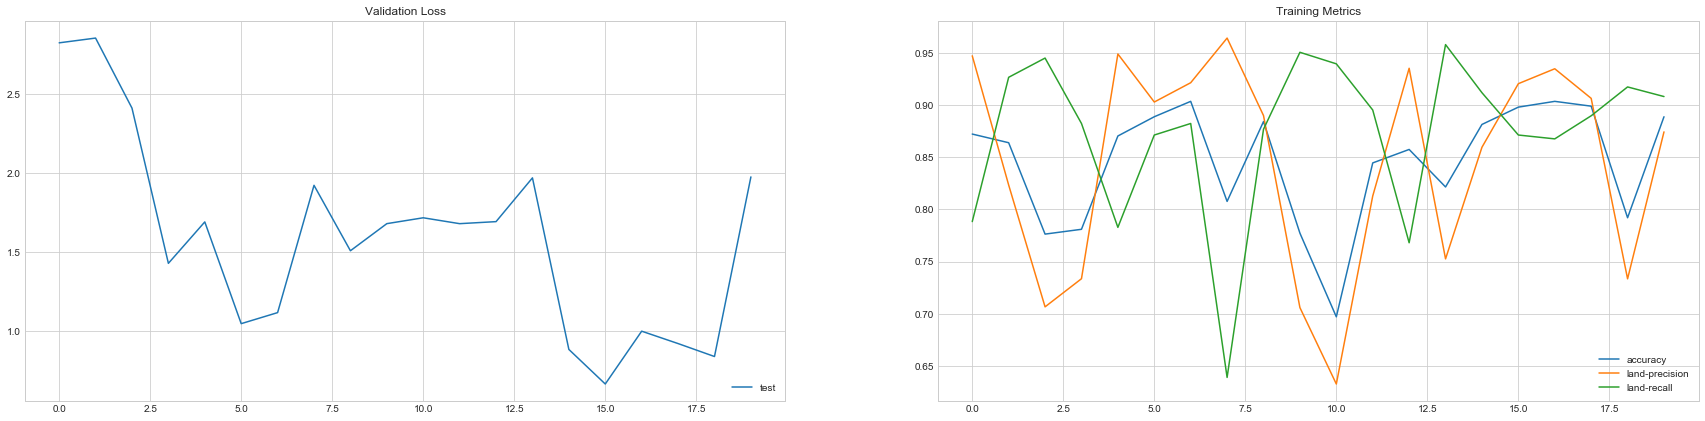

In [3]:
# ts_loss_arr, ts_acc_arr, ts_precision_arr, ts_recall_arr
oj = Plot(rows=1, columns=2, fig_size=(30,7))
ts_loss_df = pd.DataFrame(ts_loss_arr, columns=['test'])
oj.vizualize(data=ts_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Validation Loss'})
ts_data = pd.DataFrame(np.column_stack((ts_acc_arr, ts_precision_arr, ts_recall_arr)), columns=['accuracy', 'land-precision', 'land-recall'])
oj.vizualize(data=ts_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

## TRAIN MODEL: Overlayed Images [Central crop: 128 x 128]

In [ ]:
if train:
    tr_obj = Train(dict(inp_img_shape=[400,400,3],
                   crop_shape=[128,128,3],
                   out_img_shape=[224, 224, 3],
                   use_checkpoint=True,
                   save_checkpoint=True,
                   write_tensorboard_summary=False
                   ),
              which_net=which_net,  # vgg
              image_type=image_type)
    tr_acc_arr, tr_loss_arr, cv_acc_arr, cv_loss_arr = tr_obj.run(num_epochs=3, num_batches=max_batches)# + 1)